# **Stock Prices Predictions with Machine Learning**

This Notebook will contain all the data engineering, the data analysis and the modeling phases needed to predict stock prices using a deep learning model.
The stocks analyzed will be the following:
* IBM
* AAPL (Apple Inc.)
* AMZN (Amazon Inc.)
* GOOGL (Alphabet Inc.)
The model will be


A couple of sources will be used to gather the dataset.

## Data gathering

Gatering data from Yahoo Finance

Target symbols:

In [70]:
ibm = 'IBM' 
aapl = 'AAPL'
amzn = 'AMZN'
googl = 'GOOGL'

Setting dataset record start date and end date:
* start will be just set to 1st Genuary 1900, in order to retrieve the logest possible time series
* end time will be today date

In [73]:
import datetime

In [74]:
start = datetime.datetime(1900, 1, 1)
end = datetime.date.today()

## Gathering data from Yahoo! Finance

Data from Yahoo! Finance are provided in a straight order pandas dataframe (first record first). This means that the data in it will be in reverse order respect to the Alpha Vantage API provided data order.

In [75]:
# yfinance is a Yahoo! Finance market data downloader,
# that allows to access Yahoo finance data after Yahoo
# has discontinued support for this API
import yfinance as yf

#### ***IBM*** data:

In [76]:
df_yf_ibm = yf.download(ibm, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


#### ***Apple Inc.*** data:

In [77]:
df_yf_aapl = yf.download(aapl, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


#### ***Amazon.com Inc.*** data:

In [78]:
df_yf_amzn = yf.download(amzn, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


#### ***Alphabet Inc.*** data:

In [79]:
df_yf_googl = yf.download(googl, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


## EDA

This section contains an exploratory data analysis on the dataset. This will allow to to have a more clean view of the source data features dynamics over time and to spot possible patterns in data, if any.

### Data soureces comparison:

First off, comparing data from the two sources would allow to take a usage strategy.

#### ***IBM*** data:

Newest data available:

In [20]:
df_yf_ibm.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-09,121.900002,122.599998,121.050003,122.099998,122.099998,4717000
2021-02-10,123.029999,123.410004,121.209999,122.239998,122.239998,4866800
2021-02-11,122.000000,122.209999,120.629997,120.910004,120.910004,5380600
2021-02-12,121.000000,121.360001,120.089996,120.800003,120.800003,3868900
2021-02-16,120.150002,120.599998,119.360001,120.070000,120.070000,6638000


Oldest data available:

In [22]:
df_yf_ibm.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,7.713333,7.713333,7.626667,7.626667,1.858243,390000
1962-01-03,7.626667,7.693333,7.626667,7.693333,1.874485,292500
1962-01-04,7.693333,7.693333,7.613333,7.616667,1.855805,262500
1962-01-05,7.606667,7.606667,7.453333,7.466667,1.819257,367500
1962-01-08,7.460000,7.460000,7.266667,7.326667,1.785148,547500


#### ***Apple Inc.*** data:

Newest data available:

In [24]:
df_yf_aapl.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-09,136.619995,137.880005,135.850006,136.009995,136.009995,76774200
2021-02-10,136.479996,136.990005,134.399994,135.389999,135.389999,73046600
2021-02-11,135.899994,136.389999,133.770004,135.130005,135.130005,64154400
2021-02-12,134.350006,135.529999,133.690002,135.369995,135.369995,60029300
2021-02-16,135.490005,136.009995,132.789993,133.190002,133.190002,80206200


Oldest data available:

In [26]:
df_yf_aapl.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100922,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095657,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088636,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090830,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093463,73449600


#### ***Amazon.com Inc.*** data:

Newest data available:

In [28]:
df_yf_amzn.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-09,3312.489990,3338.000000,3297.840088,3305.000000,3305.000000,2203500
2021-02-10,3314.000000,3317.949951,3254.000000,3286.580078,3286.580078,3151600
2021-02-11,3292.000000,3292.000000,3248.060059,3262.129883,3262.129883,2295800
2021-02-12,3250.000000,3280.250000,3233.310059,3277.709961,3277.709961,2329300
2021-02-16,3254.050049,3308.300049,3253.590088,3268.949951,3268.949951,2563200


Oldest data available:

In [30]:
df_yf_amzn.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


#### ***Alphabet Inc.*** data:

Newest data available:

In [32]:
df_yf_googl.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-09,2074.800049,2098.510010,2070.000000,2075.389893,2075.389893,1094600
2021-02-10,2083.139893,2098.879883,2052.239990,2086.479980,2086.479980,1255100
2021-02-11,2091.000000,2094.000000,2068.860107,2088.750000,2088.750000,1021200
2021-02-12,2079.770020,2099.500000,2073.570068,2095.030029,2095.030029,948500
2021-02-16,2091.750000,2145.139893,2091.750000,2110.699951,2110.699951,1548900


Oldest data available:

In [34]:
df_yf_googl.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


### Conclusions and data sources selection

Data selection strategy will be the following:
Use Yahoo! Finance source for all the stocks.

In [80]:
df_ibm = df_yf_ibm

In [81]:
df_aapl = df_yf_aapl

In [82]:
df_amzn = df_yf_amzn

In [83]:
df_googl = df_yf_googl

For *Alphabet Inc.* an alternate model will be trained too, using data from 
 stock exchange entrance date is so recent (Alphabet has gone public in August 2004), that the same amount of records are provided both by Alpha Vantage and 
from Yahoo! Finance.
Alpha Vantage dataset will be then also used to train an alternate model on *Alphabet Inc.* stock, but it will have to be reversed in order to mantain the ascending order as for the other models.

## Data visualization

Some data visualization will help to spot data dynamics.

In [84]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline

Stock volume history of IBM stock:

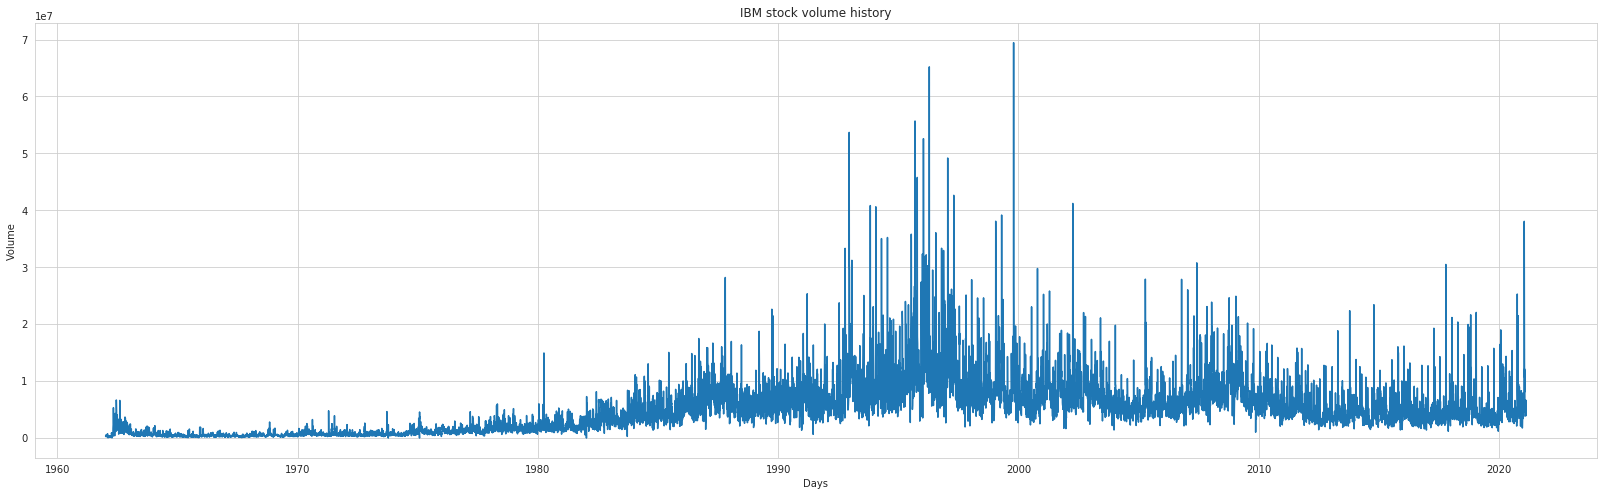

In [85]:
plt.figure(figsize=(28, 8))
plt.plot(df_ibm["Volume"])
plt.title('IBM stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

In [86]:
print("checking if any null values are present\n", df_ibm.isna().sum())

checking if any null values are present
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [87]:
print("checking if any null values are present\n", df_aapl.isna().sum())

checking if any null values are present
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [88]:
print("checking if any null values are present\n", df_amzn.isna().sum())

checking if any null values are present
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [89]:
print("checking if any null values are present\n", df_googl.isna().sum())

checking if any null values are present
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


#### ***IBM*** data:

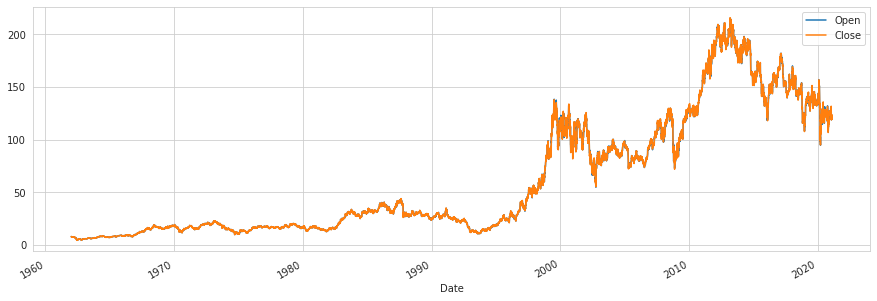

In [90]:
df_ibm[['Open', 'Close']].plot(legend=True,figsize=(15,5))

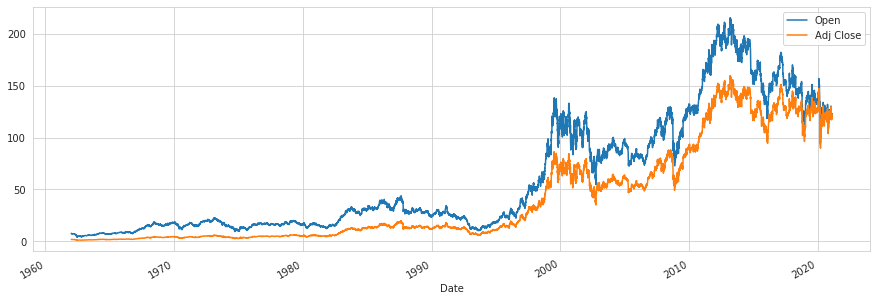

In [91]:
df_ibm[['Open', 'Adj Close']].plot(legend=True,figsize=(15,5))

Checking for inter-features correlation:

In [92]:
# Compute the correlation matrix
df_ibm_corr = df_ibm.corr()

In [93]:
import numpy as np

In [94]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_ibm_corr, dtype=bool))

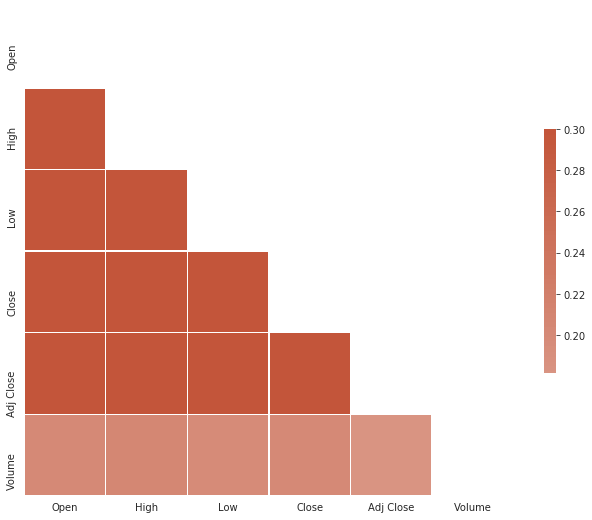

In [95]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))


# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_ibm_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Nominally, the Volume feature has a lower correlation with the other feature, but, in reality, it contains very useful data, from the moment that we know that Open, High, Low and Close value are all mostly linearly correlated to Adj Close value (our target feature). From what we can see in the pairplot, we can expect the volume to be pretty high when the value of the stock is low and to get lower when the value of the stock is high. 

#### ***Apple Inc.*** data:

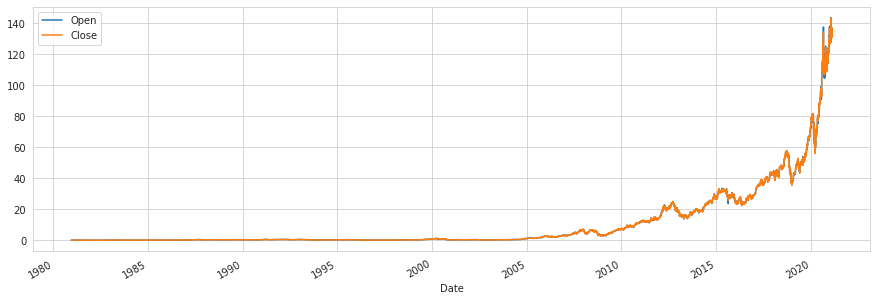

In [96]:
df_aapl[['Open', 'Close']].plot(legend=True,figsize=(15,5))

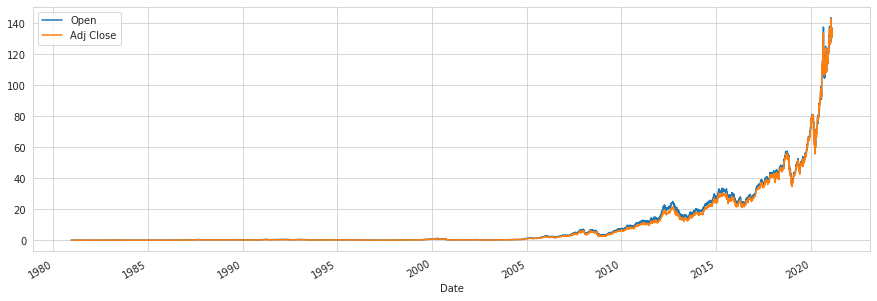

In [97]:
df_aapl[['Open', 'Adj Close']].plot(legend=True,figsize=(15,5))

Checking for inter-features correlation:

In [98]:
# Compute the correlation matrix
df_aapl_corr = df_aapl.corr()

In [99]:
import numpy as np

In [100]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_aapl_corr, dtype=bool))

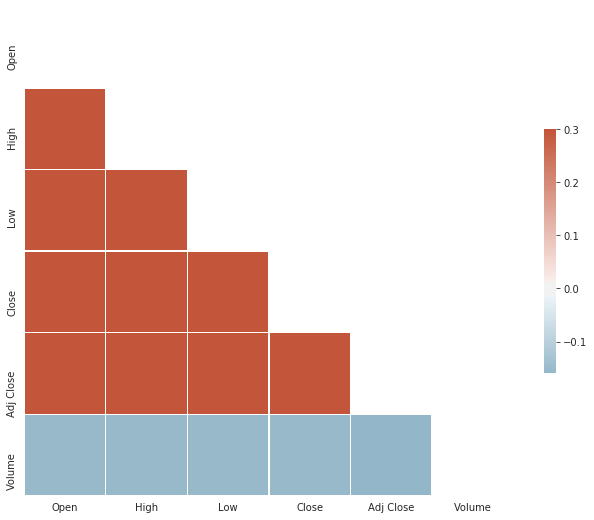

In [101]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))


# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_aapl_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

"Volume" feature has a lower correlation with the other features here we can clearly spot the expected correlation as hypotized about IBM stock.

In [103]:
import plotly.graph_objects as go
#import chart_studio.plotly as py

In [104]:
trace_ibm = {
    'x': df_ibm.index,
    'open': df_ibm.Open,
    'close': df_ibm.Close,
    'high': df_ibm.High,
    'low': df_ibm.Low,
    'type': 'candlestick',
    'name': 'IBM',
    'showlegend': True
}


In [105]:
ibm_data = [trace_ibm]
# Config graph layout
layout = go.Layout({
    'title': {
        'text': 'IBM (IBM) Moving Averages',
        'font': {
            'size': 15
        }
    }
})


In [106]:
#py.iplot(ibm_data)

In [107]:
df_ibm.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,7.713333,7.713333,7.626667,7.626667,1.858243,390000
1962-01-03,7.626667,7.693333,7.626667,7.693333,1.874485,292500
1962-01-04,7.693333,7.693333,7.613333,7.616667,1.855805,262500
1962-01-05,7.606667,7.606667,7.453333,7.466667,1.819257,367500
1962-01-08,7.460000,7.460000,7.266667,7.326667,1.785148,547500


In [108]:
#ax = sns.boxplot(x="Open", y="Close", data=df_ibm)

### Feature Engineering

In this section we well use some basic feature engineering on the data.

#### Moving average

Moving average is a value that can smooth the data in order to have good predictions:

In [109]:
# moving average sizes
ma_d_sz = [10,20,50]

for mds in ma_d_sz:
    column_name = "%s_ac_ma" %(str(mds))    
    df_ibm[column_name] = df_ibm['Adj Close'].rolling(window=mds,center=False).mean()

In [110]:
df_ibm.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1962-01-02,7.713333,7.713333,7.626667,7.626667,1.858243,390000,NaN,NaN,NaN
1962-01-03,7.626667,7.693333,7.626667,7.693333,1.874485,292500,NaN,NaN,NaN
1962-01-04,7.693333,7.693333,7.613333,7.616667,1.855805,262500,NaN,NaN,NaN
1962-01-05,7.606667,7.606667,7.453333,7.466667,1.819257,367500,NaN,NaN,NaN
1962-01-08,7.460000,7.460000,7.266667,7.326667,1.785148,547500,NaN,NaN,NaN


In [111]:
df_ibm.fillna(method='backfill', inplace=True)

In [112]:
df_ibm.tail()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2021-02-10,123.029999,123.410004,121.209999,122.239998,122.239998,4866800,119.632872,121.846537,123.027110
2021-02-11,122.000000,122.209999,120.629997,120.910004,120.910004,5380600,119.874217,121.629720,123.007486
2021-02-12,121.000000,121.360001,120.089996,120.800003,120.800003,3868900,120.200284,121.306254,122.992767
2021-02-16,120.150002,120.599998,119.360001,120.070000,120.070000,6638000,120.312235,120.974906,122.934634
2021-02-17,119.269997,120.559998,119.019997,119.970001,119.970001,3959100,120.522736,120.607473,122.894434


In [113]:
df_ibm.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1962-01-02,7.713333,7.713333,7.626667,7.626667,1.858243,390000,1.831034,1.806507,1.787152
1962-01-03,7.626667,7.693333,7.626667,7.693333,1.874485,292500,1.831034,1.806507,1.787152
1962-01-04,7.693333,7.693333,7.613333,7.616667,1.855805,262500,1.831034,1.806507,1.787152
1962-01-05,7.606667,7.606667,7.453333,7.466667,1.819257,367500,1.831034,1.806507,1.787152
1962-01-08,7.460000,7.460000,7.266667,7.326667,1.785148,547500,1.831034,1.806507,1.787152


In [114]:
start_date = '1999-1-1'
end_date = '2000-12-31'
df_ibm[start_date:end_date]

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1999-01-04,92.50000,93.2500,90.75000,91.50000,57.222702,8149600,57.336052,54.627357,51.017732
1999-01-05,91.50000,94.9375,91.40625,94.81250,59.294292,9907600,57.900853,55.024086,51.318054
1999-01-06,95.15625,96.3750,94.25000,94.37500,59.020687,9539600,58.287810,55.361208,51.614465
1999-01-07,93.96875,96.1875,93.50000,95.09375,59.470184,8306800,58.536012,55.705169,51.910498
1999-01-08,95.50000,96.0000,92.81250,93.78125,58.649353,9176800,58.616137,55.988545,52.181919
...,...,...,...,...,...,...,...,...,...
2000-12-22,84.50000,89.3750,84.50000,89.00000,56.185520,9514000,56.662942,59.071738,61.002286
2000-12-26,89.00000,89.5625,84.25000,84.81250,53.541969,6052300,56.019807,58.641666,60.697857
2000-12-27,84.75000,88.1250,83.56250,84.68750,53.463047,8245100,55.439805,58.225405,60.365840


In [115]:
df_ibm.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '10_ac_ma',
       '20_ac_ma', '50_ac_ma'],
      dtype='object')

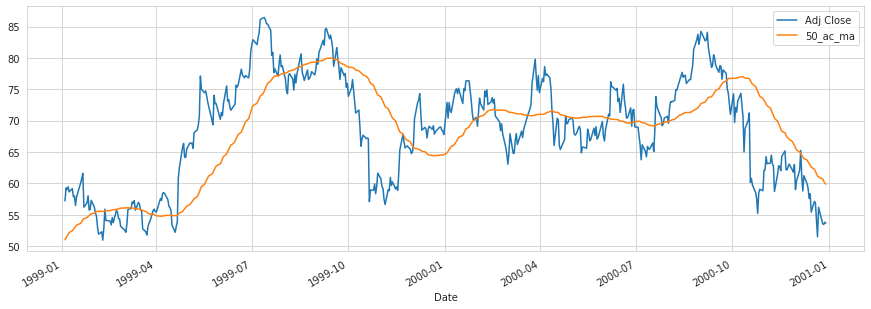

In [117]:
df_ibm[start_date:end_date][['Adj Close', '50_ac_ma']].plot(legend=True,figsize=(15,5))

My hipotesis is that IBM can have an annual pattern, from september to october

### Hyperparameters Tuning

DeepAR is the model of choice of this project.
This model expects input data to be already test-train splitted.
A big part of the model design has to be done looking close at data.
More specifically, defining an hyperparmeter as the context length  about the data:
* Context length
* Prediction length

### Prediction length

This is the length of the time series future predictions in days. It will be conveniently set to 5 days (exactly a week of trading hours) because a shorter interval would be of little significance.
A longer interval could be interesting from an application point of view, but it can be challenging in terms of model performances.

### Context length

Context length can be either:
* chosen as a fixed value (e.g. 2 x prediction_length),
* designed on patterns or seasonality observed in the data.

To explore this second option, we will refer to what we've found during the EDA stage.

In [107]:
import deepar_utils
#Define parameters
interval = 'D' #Use D or H

assert interval == 'D' or interval == 'H'

if interval == 'D':
    prediction_length = 7 #when interval = D    
    context_length = prediction_length*2
elif interval == 'H':
    prediction_length = 2184 #when interval = H
    context_length = prediction_length*2
    
    
mnemonics = ['CON','DAI','PAH3','BMW','VOW3']
target_column = 'EndPrice'
covariate_columns = ['StartPrice', 'MinPrice', 'MaxPrice']

train_test_split = 0.8
num_test_windows = 4
    
hyperparameters = {
    "prediction_length": str(prediction_length), #number of time-steps model is trained to predict, always generates forecasts with this length
    "context_length": str(context_length), #number of time-points that the model gets to see before making the prediction, should be about same as the prediction_length
    "time_freq": interval, #granularity of the time series in the dataset
    "epochs": "200", #maximum number of passes over the training data
    "early_stopping_patience": "40", #training stops when no progress is made within the specified number of epochs
    "num_layers": "2", #number of hidden layers in the RNN, typically range from 1 to 4    
    "num_cells": "40", #number of cells to use in each hidden layer of the RNN, typically range from 30 to 100
    "mini_batch_size": "128", #size of mini-batches used during training, typically values range from 32 to 512
    "learning_rate": "1e-3", #learning rate used in training. Typical values range from 1e-4 to 1e-1
    "dropout_rate": "0.1", # dropout rate to use for regularization, typically less than 0.2. 
    "likelihood": "gaussian" #noise model used for uncertainty estimates - gaussian/beta/negative-binomial/student-T/deterministic-L1
}

ModuleNotFoundError: No module named 'sagemaker'

#### Yahoo Finance data plot:

In [ ]:
df_av_adj_close.plot(legend=True)

In [ ]:
googl_init_val = df_av_googl_ac[df_av_googl_ac.last_valid_index()]

so every value before this date could be conveniently set to 0, first valid value or other values. I will put it equal to first initial value:

In [ ]:
df_av_adj_close['GOOGL'].fillna(googl_init_val, inplace=True)

In [ ]:
df_av_adj_close.plot(legend=True)

I will try to pair plot them in order to spot any correlation between the stocks:

In [72]:
import seaborn as sns

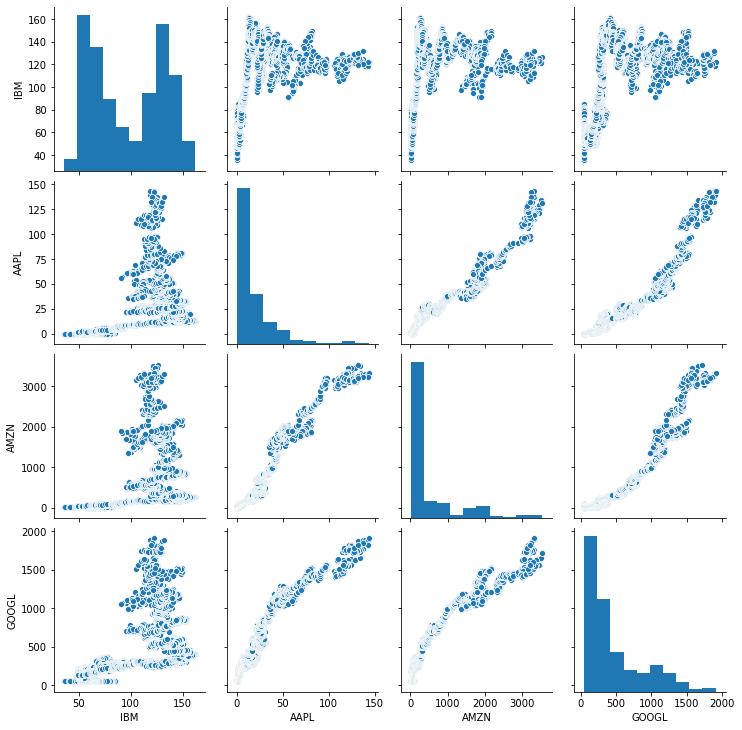

In [73]:
sns.pairplot(df_av_adj_close)

#### Alpha vantage Finance data plot:

### SMA

For each of the symbols, a simple moving average could be calculated, in order to do so 4 new dataframe will be created, containing the moving average of each symbol.

first setting window size:

In [63]:
ws = 7

In [64]:
ibm_ma = df_av_ibm['adjusted close'].rolling(window=ws).mean()
df_av_ibm['adjusted close moving average'] = ibm_ma

In [65]:
df_av_ibm.head()

,open,high,low,close,adjusted close,volume,dividend amount,split coefficient,adjusted close moving average
1999-11-01,98.50,98.81,96.37,96.75,61.535122,9551800,0.0,1.0,NaN
1999-11-02,96.75,96.81,93.69,94.81,60.301239,11105400,0.0,1.0,NaN
1999-11-03,95.87,95.94,93.50,94.37,60.021389,10369100,0.0,1.0,NaN
1999-11-04,94.44,94.44,90.00,91.56,58.234168,16697600,0.0,1.0,NaN
1999-11-05,92.75,92.94,90.19,90.25,57.400979,13737600,0.0,1.0,NaN


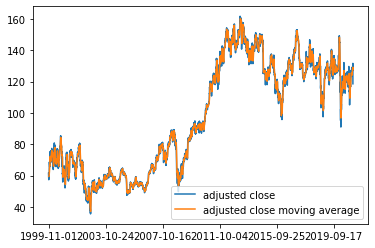

In [66]:
df_av_ibm['adjusted close'].plot(legend=True)
df_av_ibm['adjusted close moving average'].plot(legend=True)

In [45]:
ibm_ma.describe()

count    5335.000000
mean       97.515987
std        34.626072
min        37.188993
25%        63.238077
50%        92.002136
75%       129.347802
max       160.227180
Name: adjusted close, dtype: float64

Computing metrics on the moving average

In [50]:
from sklearn.metrics import mean_squared_error

In [28]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import datetime
import pyflux